In [128]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import machine learning libraries
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNetCV

# get rid of depreciation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) 

In [129]:
#brings in the csv
data = pd.read_csv("/Users/jacobbills/Desktop/Economics/Twitter_sentiment_DJIA30/Combined_stocks.csv") 

### Let's make some percents for the different sentiment scores 
#### (ie. percent of total tweets that were positive/negative/neutral)


In [130]:
#checking what we have
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14182 entries, 0 to 14181
Data columns (total 56 columns):
Unnamed: 0    14182 non-null int64
Date          14182 non-null object
HIGH          14182 non-null float64
CLOSE         14182 non-null float64
OPEN          14182 non-null float64
LOW           14182 non-null float64
NUM_NEG       14182 non-null int64
NUM_NEU       14182 non-null int64
NUM_POS       14182 non-null int64
TW            14182 non-null int64
weekend       14182 non-null int64
NUM_NEG1      14182 non-null int64
NUM_NEG2      14182 non-null int64
NUM_NEG3      14182 non-null int64
NUM_NEU1      14182 non-null int64
NUM_NEU2      14182 non-null int64
NUM_NEU3      14182 non-null int64
NUM_POS1      14182 non-null int64
NUM_POS2      14182 non-null int64
NUM_POS3      14182 non-null int64
TW1           14182 non-null int64
TW2           14182 non-null int64
TW3           14182 non-null int64
CLOSE1        14182 non-null float64
CLOSE2        14182 non-null float64
CLO

In [131]:
# create percentages
sentiments = ['NUM_NEG', 'NUM_NEG1', 'NUM_NEG2', 'NUM_NEG3','NUM_NEU','NUM_NEU1','NUM_NEU2','NUM_NEU3','NUM_POS',
              'NUM_POS1','NUM_POS2', 'NUM_POS3']
for e in sentiments:
    if e.endswith("1"):
        data[e+"_PER"] = data[e]/data['TW1']
    elif e.endswith("2"):
        data[e+"_PER"] = data[e]/data['TW2']
    elif e.endswith("3"):
        data[e+"_PER"] = data[e]/data['TW3']
    else:
        data[e+"_PER"] = data[e]/data['TW']

In [132]:
# Create Dummies for each day
data['Date']= pd.to_datetime(data['Date'])
data['day'] = data['Date'].dt.day_name()

In [133]:
data =pd.get_dummies(data, columns=['day'])
data.head()

,Unnamed: 0,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,...,NUM_POS1_PER,NUM_POS2_PER,NUM_POS3_PER,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0,2013-06-04,77.24,76.02,76.50,75.96,2,12,6,20,...,0.090909,0.000000,0.000000,0,0,0,0,0,1,0
1,1,2013-06-05,76.28,74.79,76.04,74.64,0,4,2,6,...,0.300000,0.090909,0.000000,0,0,0,0,0,0,1
2,2,2013-06-06,76.25,76.24,74.75,74.64,1,9,0,10,...,0.333333,0.300000,0.090909,0,0,0,0,1,0,0
3,3,2013-06-07,78.12,78.03,76.68,76.45,2,4,11,17,...,0.000000,0.333333,0.300000,1,0,0,0,0,0,0
4,4,2013-06-08,78.12,78.03,76.68,76.45,0,3,3,6,...,0.647059,0.000000,0.333333,0,0,1,0,0,0,0


In [134]:
# seeing where there might be a problem with null values
is_null = data.columns[data.isnull().any()] 
is_null

Index(['NUM_NEG_PER', 'NUM_NEG1_PER', 'NUM_NEG2_PER', 'NUM_NEG3_PER',
       'NUM_NEU_PER', 'NUM_NEU1_PER', 'NUM_NEU2_PER', 'NUM_NEU3_PER',
       'NUM_POS_PER', 'NUM_POS1_PER', 'NUM_POS2_PER', 'NUM_POS3_PER'],
      dtype='object')

In [135]:
# about 30 missing values for each, for whatever reason
data[is_null].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14182 entries, 0 to 14181
Data columns (total 12 columns):
NUM_NEG_PER     14150 non-null float64
NUM_NEG1_PER    14150 non-null float64
NUM_NEG2_PER    14149 non-null float64
NUM_NEG3_PER    14149 non-null float64
NUM_NEU_PER     14150 non-null float64
NUM_NEU1_PER    14150 non-null float64
NUM_NEU2_PER    14149 non-null float64
NUM_NEU3_PER    14149 non-null float64
NUM_POS_PER     14150 non-null float64
NUM_POS1_PER    14150 non-null float64
NUM_POS2_PER    14149 non-null float64
NUM_POS3_PER    14149 non-null float64
dtypes: float64(12)
memory usage: 1.3 MB


In [136]:
#just fill in null values with whatever is closest
for e in is_null: 
    data[e].fillna(data[e].mean(), inplace=True)

In [137]:
# create the classes
for i in range(len(data)): 
    if data.loc[i,"CLOSE"] > data.loc[i,"OPEN"]+.25:
        # gained by more than $.25
        data.loc[i,"class"] = 1 
    elif data.loc[i,"CLOSE"] < data.loc[i,'OPEN']-.25:
        # lost by more than $.25
        data.loc[i,"class"] = 2  
    else:
        # minimal change
        data.loc[i,"class"] = 0 

In [138]:
#see how the data looks
data[["CLOSE", "OPEN", "Date", "weekend","class"]] 

,CLOSE,OPEN,Date,weekend,class
0,76.02,76.50,2013-06-04,0,2.0
1,74.79,76.04,2013-06-05,0,2.0
2,76.24,74.75,2013-06-06,0,1.0
3,78.03,76.68,2013-06-07,0,1.0
4,78.03,76.68,2013-06-08,1,1.0
5,78.03,76.68,2013-06-09,1,1.0
6,78.27,77.98,2013-06-10,0,1.0
7,76.52,77.61,2013-06-11,0,2.0
8,74.72,76.91,2013-06-12,0,2.0
9,75.21,74.46,2013-06-13,0,1.0


In [139]:
#drop out the weekend data, no trades occur on weekends
data = data.loc[data.weekend==0]
data.head() 

,Unnamed: 0,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,...,NUM_POS2_PER,NUM_POS3_PER,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,class
0,0,2013-06-04,77.24,76.02,76.50,75.96,2,12,6,20,...,0.000000,0.000000,0,0,0,0,0,1,0,2.0
1,1,2013-06-05,76.28,74.79,76.04,74.64,0,4,2,6,...,0.090909,0.000000,0,0,0,0,0,0,1,2.0
2,2,2013-06-06,76.25,76.24,74.75,74.64,1,9,0,10,...,0.300000,0.090909,0,0,0,0,1,0,0,1.0
3,3,2013-06-07,78.12,78.03,76.68,76.45,2,4,11,17,...,0.333333,0.300000,1,0,0,0,0,0,0,1.0
6,6,2013-06-10,78.61,78.27,77.98,77.69,0,6,7,13,...,0.500000,0.647059,0,1,0,0,0,0,0,1.0


In [140]:
# creating our target
target = data.CLOSE 

# target for classifiers
target_class = data["class"] 

# other columns that we don't really need for now
high = data.HIGH 
low = data.LOW 

### Creating some cleaned up datasets to use in our testing

In [141]:
# get rid of those unnecesary vars for first usable dataset
data1 = data.drop(columns=['CLOSE', 'HIGH', 'LOW', 'Unnamed: 0', 'class', 'day_Saturday', 'day_Sunday']) 

In [142]:
# create a df without the dates
data_nodate = data1.drop(columns='Date') 

In [143]:
# create a df without anything for the day of interest
data_prev = data_nodate.drop(columns=['NUM_NEG', 'NUM_NEU', 'NUM_POS', 'NUM_NEG_PER', 'NUM_NEU_PER', 'NUM_POS_PER', "TW"])

In [144]:
# creating df without opening price for the "nodate" data and previous day data
data_nopen_date = data_nodate.drop(columns='OPEN')
data_nopen_prev = data_prev.drop(columns='OPEN')

In [145]:
# turn everything into floats so that scaler is happy

data_nodate = pd.DataFrame(data_nodate, dtype='float')
data_prev = pd.DataFrame(data_prev, dtype='float')
data_nopen_date = pd.DataFrame(data_nopen_date, dtype='float')
data_nopen_prev = pd.DataFrame(data_nopen_prev, dtype='float')

In [146]:
# check to see that everything looks clean
data_nopen_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9832 entries, 0 to 14181
Data columns (total 60 columns):
weekend          9832 non-null float64
NUM_NEG1         9832 non-null float64
NUM_NEG2         9832 non-null float64
NUM_NEG3         9832 non-null float64
NUM_NEU1         9832 non-null float64
NUM_NEU2         9832 non-null float64
NUM_NEU3         9832 non-null float64
NUM_POS1         9832 non-null float64
NUM_POS2         9832 non-null float64
NUM_POS3         9832 non-null float64
TW1              9832 non-null float64
TW2              9832 non-null float64
TW3              9832 non-null float64
CLOSE1           9832 non-null float64
CLOSE2           9832 non-null float64
CLOSE3           9832 non-null float64
AXP              9832 non-null float64
BA               9832 non-null float64
CAT              9832 non-null float64
CSCO             9832 non-null float64
CVX              9832 non-null float64
DD               9832 non-null float64
DIS              9832 non-null flo

## Now that the data is clean, we can try to run some different models on it

In [147]:
#scale each of the three sets with open
scaler = StandardScaler() 

scaler.fit(data_nodate)
scaled_df_noo = scaler.transform(data_nodate)

scaler.fit(data_prev)
scaled_prevo = scaler.transform(data_prev)

In [148]:
# break into test and training sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(scaled_df_noo, target, test_size=.2, random_state = 11)
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_prevo, target, test_size=.2, random_state = 11)

In [149]:
#plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=5)

In [150]:
# elastic net without dates
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train1, y_train1)
train_predictions = clf.predict(X_train1)
test_predictions = clf.predict(X_test1)
print("Train MSE: {}".format(mean_squared_error(y_train1, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test1, test_predictions)))

Train MSE: 0.6975927006156463
Test MSE: 0.6147122494261432


In [151]:
# showing values assigned to every variable in the elastic net
sorted(list(zip(data_nodate, clf.coef_)), key=lambda x: abs(x[1]))

[('NUM_NEG', -0.0),
 ('NUM_NEU', -0.0),
 ('NUM_POS', 0.0),
 ('TW', -0.0),
 ('weekend', 0.0),
 ('NUM_NEG1', 0.0),
 ('NUM_NEG2', 0.0),
 ('NUM_NEG3', 0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_NEU3', -0.0),
 ('NUM_POS1', 0.0),
 ('NUM_POS2', 0.0),
 ('NUM_POS3', 0.0),
 ('TW1', -0.0),
 ('TW2', 0.0),
 ('TW3', -0.0),
 ('CLOSE2', 0.0),
 ('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('PFE', -0.0),
 ('PG', -0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('UNH', 0.0),
 ('UTX', -0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', -0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', -0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEG3_PER', 0.0),
 ('NUM_NEU_PER', -0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_NEU3_PER', -0.0),
 ('NUM_POS_PER', 0.0),
 ('NUM

In [152]:
# elastic net without today's data
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train2, y_train2)
train_predictions = clf.predict(X_train2)
test_predictions = clf.predict(X_test2)
print("Train MSE: {}".format(mean_squared_error(y_train2, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test2, test_predictions)))

Train MSE: 0.7016509280024095
Test MSE: 0.6184034738226846


In [153]:
# shows significance assigned to each variable in the elastic net model
sorted(list(zip(data_prev, clf.coef_)), key=lambda x: abs(x[1]))

[('weekend', 0.0),
 ('NUM_NEG1', -0.0),
 ('NUM_NEG2', 0.0),
 ('NUM_NEG3', -0.0),
 ('NUM_NEU1', -0.0),
 ('NUM_NEU2', -0.0),
 ('NUM_NEU3', -0.0),
 ('NUM_POS1', 0.0),
 ('NUM_POS2', 0.0),
 ('NUM_POS3', 0.0),
 ('TW1', -0.0),
 ('TW2', -0.0),
 ('TW3', -0.0),
 ('CLOSE2', 0.0),
 ('AXP', -0.0),
 ('BA', 0.0),
 ('CAT', 0.0),
 ('CSCO', -0.0),
 ('CVX', 0.0),
 ('DD', -0.0),
 ('DIS', -0.0),
 ('GE', -0.0),
 ('GS', 0.0),
 ('HD', -0.0),
 ('IBM', 0.0),
 ('INTC', -0.0),
 ('JNJ', 0.0),
 ('JPM', -0.0),
 ('KO', -0.0),
 ('MCD', 0.0),
 ('MMM', 0.0),
 ('MRK', -0.0),
 ('MSFT', -0.0),
 ('NKE', -0.0),
 ('PFE', -0.0),
 ('PG', -0.0),
 ('T', -0.0),
 ('TRV', 0.0),
 ('UNH', 0.0),
 ('UTX', -0.0),
 ('V', 0.0),
 ('VZ', -0.0),
 ('WMT', -0.0),
 ('XOM', 0.0),
 ('NUM_NEG1_PER', -0.0),
 ('NUM_NEG2_PER', 0.0),
 ('NUM_NEG3_PER', 0.0),
 ('NUM_NEU1_PER', 0.0),
 ('NUM_NEU2_PER', -0.0),
 ('NUM_NEU3_PER', -0.0),
 ('NUM_POS1_PER', 0.0),
 ('NUM_POS2_PER', 0.0),
 ('NUM_POS3_PER', 0.0),
 ('day_Friday', 0.0),
 ('day_Monday', 0.0),
 ('day_T

In [154]:
# scale the dataset wihtout opening prices
scaler.fit(data_nopen_date)
scaled_df_non = scaler.transform(data_nopen_date)

scaler.fit(data_nopen_prev)
scaled_prevn = scaler.transform(data_nopen_prev)

In [155]:
# create training sets
X_train4, X_test4, y_train4, y_test4 = train_test_split(scaled_df_non, target, test_size=.2, random_state = 11)
X_train5, X_test5, y_train5, y_test5 = train_test_split(scaled_prevn, target, test_size=.2, random_state = 11)

In [156]:
# Running the Elastic net with no dates
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train4, y_train4)
train_predictions = clf.predict(X_train4)
test_predictions = clf.predict(X_test4)
print("Train MSE: {}".format(mean_squared_error(y_train4, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test4, test_predictions)))
print(sorted(list(zip(data_nopen_date, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 0.9258320276420248
Test MSE: 0.9284107449636377
[('NUM_NEG', -0.0), ('NUM_NEU', -0.0), ('NUM_POS', 0.0), ('TW', -0.0), ('weekend', 0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', 0.0), ('NUM_NEG3', 0.0), ('NUM_NEU1', -0.0), ('NUM_NEU2', -0.0), ('NUM_NEU3', -0.0), ('NUM_POS1', -0.0), ('NUM_POS2', 0.0), ('NUM_POS3', 0.0), ('TW1', -0.0), ('TW2', -0.0), ('TW3', -0.0), ('AXP', -0.0), ('BA', 0.0), ('CAT', 0.0), ('CSCO', -0.0), ('CVX', 0.0), ('DD', -0.0), ('DIS', -0.0), ('GE', -0.0), ('GS', 0.0), ('HD', -0.0), ('IBM', 0.0), ('INTC', -0.0), ('JNJ', 0.0), ('JPM', 0.0), ('KO', -0.0), ('MCD', 0.0), ('MMM', 0.0), ('MRK', -0.0), ('MSFT', -0.0), ('NKE', -0.0), ('PFE', -0.0), ('PG', -0.0), ('T', -0.0), ('TRV', 0.0), ('UNH', -0.0), ('UTX', -0.0), ('V', 0.0), ('VZ', -0.0), ('WMT', 0.0), ('XOM', -0.0), ('NUM_NEG1_PER', 0.0), ('NUM_NEG2_PER', 0.0), ('NUM_NEG3_PER', 0.0), ('NUM_NEU_PER', -0.0), ('NUM_NEU1_PER', 0.0), ('NUM_NEU2_PER', -0.0), ('NUM_NEU3_PER', -0.0), ('NUM_POS1_PER', -0.0), ('NUM_POS2_PER'

In [157]:
# elastic net without anything from the day being predicted
clf = ElasticNetCV(l1_ratio=[.1, .3, .5, .7, .8, .9, .95, .99, 1], alphas= [.1, 1, 5, 10], cv=5) #basic Elastic Net with CV
clf.fit(X_train5, y_train5)
train_predictions = clf.predict(X_train5)
test_predictions = clf.predict(X_test5)
print("Train MSE: {}".format(mean_squared_error(y_train5, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test5, test_predictions)))
print(sorted(list(zip(data_nopen_prev, clf.coef_)), key=lambda x: abs(x[1])))

Train MSE: 0.9726292029699234
Test MSE: 0.9722017680023588
[('weekend', 0.0), ('NUM_NEG1', -0.0), ('NUM_NEG2', -0.0), ('NUM_NEG3', -0.0), ('NUM_NEU1', -0.0), ('NUM_NEU2', -0.0), ('NUM_NEU3', -0.0), ('NUM_POS1', 0.0), ('NUM_POS2', 0.0), ('NUM_POS3', 0.0), ('TW1', -0.0), ('TW2', -0.0), ('TW3', -0.0), ('AXP', 0.0), ('BA', 0.0), ('CAT', 0.0), ('CSCO', -0.0), ('CVX', 0.0), ('DD', -0.0), ('DIS', 0.0), ('GE', -0.0), ('GS', 0.0), ('HD', 0.0), ('IBM', 0.0), ('INTC', -0.0), ('JNJ', 0.0), ('JPM', -0.0), ('KO', -0.0), ('MCD', -0.0), ('MMM', 0.0), ('MRK', -0.0), ('MSFT', -0.0), ('NKE', 0.0), ('PFE', -0.0), ('PG', -0.0), ('T', -0.0), ('TRV', 0.0), ('UNH', 0.0), ('UTX', -0.0), ('V', 0.0), ('VZ', -0.0), ('WMT', -0.0), ('XOM', -0.0), ('NUM_NEG1_PER', -0.0), ('NUM_NEG2_PER', -0.0), ('NUM_NEG3_PER', 0.0), ('NUM_NEU1_PER', 0.0), ('NUM_NEU2_PER', -0.0), ('NUM_NEU3_PER', -0.0), ('NUM_POS1_PER', 0.0), ('NUM_POS2_PER', 0.0), ('NUM_POS3_PER', 0.0), ('day_Friday', 0.0), ('day_Monday', 0.0), ('day_Thursday', -0.

### Preliminary Results
As we see it isn't very interesting to use the data in an elastic net to predict future prices because it ends up that the only thing you want to know is what the opening price/yesterday's price is, and then how people were tweeting the day of (possibly after closing). 

### Refining our analysis
Lets change up our methodology a bit. We will instead try to predict if tweets can forecast if the stock is going to go up or down. The "previous" data is the most important sort here.

In [158]:
# importing Machine Learning libraries
from sklearn.neighbors import KNeighborsClassifier
# importing different Bayesian models
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB 
# importing support vector machine
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
# importing some ensemble models we might want to use
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier 

# importing GridSearchCV to do some cross validation
from sklearn.model_selection import GridSearchCV 

# importing libraries to measure metrics
#different ways of scoring
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error 
# classification report
from sklearn.metrics import classification_report 
# confusion matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

In [159]:
# create training sets from the previous day data (with and without OPEN)
X_traincO, X_testcO, y_traincO, y_testcO = train_test_split(scaled_prevo, target_class, test_size=.2, random_state = 11)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(scaled_prevn, target_class, test_size=.2, random_state = 11)

In [160]:
# K Nearest Neighbors with open
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_traincO, y_traincO)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_traincO)
print("Train F1: {}".format(f1_score(y_traincO, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testcO)
print(classification_report(y_testcO, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_traincO, y_pred_train),
                                                     accuracy_score(y_testcO, y_pred_test)))

Best Params: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Train F1: [0.65745856 0.49035235 0.41751746]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.65      0.58       801
         1.0       0.40      0.38      0.39       630
         2.0       0.32      0.22      0.26       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.41      0.42      0.41      1967
weighted avg       0.43      0.45      0.43      1967

Train Accuracy: 0.5500317863954227	Test accuracy: 0.44636502287747837


In [161]:
# confusion matrix to evaluate performance
confusion_matrix(y_testcO, y_pred_test)

array([[518, 178, 105],
       [247, 242, 141],
       [228, 190, 118]])

In [162]:
# K Nearest Neighbors without open
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainc, y_trainc)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainc)
print("Train F1: {}".format(f1_score(y_trainc, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testc)
print(classification_report(y_testc, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainc, y_pred_train),
                                                     accuracy_score(y_testc, y_pred_test)))
print(confusion_matrix(y_testc, y_pred_test))

Best Params: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Train F1: [0.65819638 0.49245599 0.41861716]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.65      0.58       801
         1.0       0.40      0.39      0.39       630
         2.0       0.32      0.22      0.26       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.41      0.42      0.41      1967
weighted avg       0.43      0.45      0.43      1967

Train Accuracy: 0.5513032422123331	Test accuracy: 0.44687341128622265
[[517 178 106]
 [243 245 142]
 [228 191 117]]


## What Are We Learning Here?
### First:
So first of all this KNN model is overfitting, but not too much. Removing "OPEN" made it only marginally better (talking like 4 more in the second class and 1 less in the other classes) so that indicates that OPEN is not a driving force for this problem (unlike the basic prediction problem).

### Second: 
It seems to mostly put things in the first class (no major change) which works okay but not great. It just guesses that there will not be a change in stock price and hopes for the best. It is really bad at predicting a drop in prices, so I'm not sure what is going on there, except that it probaly trained itself to mostly put things in the first class.

### Next Steps:
Next we'll try a random forest, since we can get feature importances from that which may give valuable information about what variables to keep and what ones to drop so that we stop overfitting the nearest neighbors. 

In [163]:
# RandomForestClassifier with Opening prices
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_traincO, y_traincO)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_traincO)
print("Train F1: {}".format(f1_score(y_traincO, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testcO)
print(classification_report(y_testcO, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_traincO, y_pred_train),
                                                     accuracy_score(y_testcO, y_pred_test)))
print(confusion_matrix(y_testcO, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 9}
Train F1: [0.63246959 0.68599222 0.67032744]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.50      0.56       801
         1.0       0.39      0.44      0.42       630
         2.0       0.32      0.38      0.35       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.45      0.44      0.44      1967
weighted avg       0.48      0.45      0.46      1967

Train Accuracy: 0.6617927527018436	Test accuracy: 0.4489069649211998
[[398 210 193]
 [104 279 247]
 [109 221 206]]


In [170]:
rfcb = RandomForestClassifier(n_estimators = 100, max_features='sqrt', min_samples_leaf=9, max_depth
                             = 11, class_weight='balanced', random_state=9)
rfcb.fit(X_traincO, y_traincO)
feature_imp_rfc1 = sorted(list(zip(data_prev, rfcb.feature_importances_)), key=lambda x: x[1], reverse=True)

In [164]:
# RandomForestClassifier without Opening prices
rfc = RandomForestClassifier()

gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainc, y_trainc)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainc)
print("Train F1: {}".format(f1_score(y_trainc, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testc)
print(classification_report(y_testc, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainc, y_pred_train),
                                                     accuracy_score(y_testc, y_pred_test)))
print(confusion_matrix(y_testc, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 9, 'n_estimators': 20, 'random_state': 9}
Train F1: [0.58290386 0.51775148 0.4600639 ]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57       801
         1.0       0.39      0.46      0.42       630
         2.0       0.30      0.35      0.32       536

   micro avg       0.44      0.44      0.44      1967
   macro avg       0.45      0.44      0.44      1967
weighted avg       0.48      0.44      0.45      1967

Train Accuracy: 0.5238397965670692	Test accuracy: 0.44483985765124556
[[398 212 191]
 [ 96 290 244]
 [ 99 250 187]]


In [172]:
rfcb2 = RandomForestClassifier(class_weight= 'balanced', max_depth= 7, max_features= 'log2', min_samples_leaf= 9, 
                               n_estimators= 20, random_state= 9)
rfcb2.fit(X_trainc, y_trainc)
feature_imp_rfc2 = sorted(list(zip(data_nopen_prev, rfcb2.feature_importances_)), key=lambda x: x[1], reverse=True)

### Finding Important Features
Now that we've run our Random Forest we can go ahead and find feature importance based off the Random Forest model. Below we use a set of functinos to extract the most important features and use that to guide further analysis.

In [63]:
def key_extract(dic):
    #turns the dictionary into a data frame
    y = pd.DataFrame.from_dict(dic, orient='index') 
    # list of the names in the dataframe
    y = y.index 
    return y

# function to extract a list of features above a given sensitivty
def feature_extract(data_frame, feature_importances, sensitivity): 
    #creates a dictionary from the model's feature importance
    coef_dict = dict((zip(data_frame, feature_importances))) 
    # another dictionary
    coef_list = {} 
    # runs through the zipped dictionary 
    for key in coef_dict: 
        # extracts value for the key
        x = coef_dict.get(key) 
        # if the absolute value is bigger than the sensitivity
        if abs(x) > sensitivity:  
            # adds a new entry to the other dictionary
            coef_list[key] = x  
        # if the coefficient isn't big enough
        else: 
            # move to the next key
            pass 
    # uses a previous function I wrote to make a list of the names of those coeff    
    coef_list = key_extract(coef_list) 
    # returns that list
    return coef_list 

# creates a dictionary from a list of tuples using another list of names
def best_feature_dict(list_, features_imp): 
    y = {}
    for e in list_:
        y[e] = dict(features_imp).get(e)
    return y

#plots the features importances
def best_feature_plot(list_, features_imp, ticks=90): 
    y = best_feature_dict(list_, features_imp)
    plt.bar(y.keys(),y.values())
    plt.title("Feature Importance")
    plt.xticks(rotation=ticks)
    plt.ylabel("Percent Used")
    plt.grid(True)
    
#combines these functions into one nice one    
def features_full(data_frame, feature_importances, sensitivity): 
    x = feature_extract(data_frame, feature_importances, sensitivity)
    z = sorted(list(zip(data_frame, feature_importances)), key=lambda x: x[1], reverse=True)
    y = best_feature_plot(x, z)
    return x, y

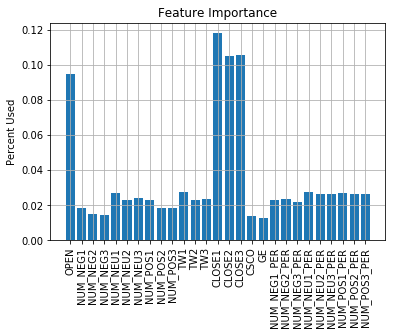

In [171]:
best_feat1, best_featplt1 = features_full(data_prev, rfcb.feature_importances_, .01)

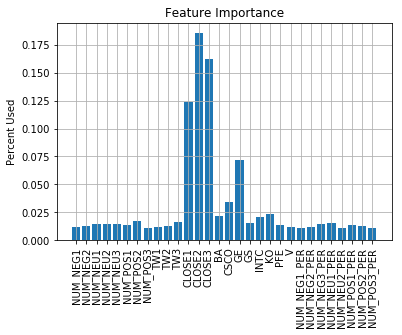

In [173]:
best_feat2, best_featplt2 = features_full(data_nopen_prev,rfcb2.feature_importances_, .01)

### Most Important Features - Findings
Sentiments do indeed play a role in how these get classified, (though there is some weirdness because of the low number of estimators), however they are overshadowed by company level dummies and in the no-OPEN model, prior closing prices. They don't seem to be the best predictor of future price changes.

### Next steps
Next, we'll look at correlations between these higher importance features and then maybe mess with the data set a bit more to get a less overfitting k-nearest neighbors model (since that one is still working the best). Might try an SVM model too, since lower amounts of features helps a lot with that. 

Note: Having OPEN doesn't make a huge difference on the final outcome (makes it more predictive of stock rises at the expense of predicting stock drops), but it does greatly change the feature selection. 

In [72]:
# function that will shows where there is high correlation
def corr_extract(var, sensitivity): 
    #create a dictionary that will give the name and value
    y = dict()
    # set up the counter
    count = 0 
    for e in var:
        #most common is lower correlation so I'll get rid of those first
        if abs(e)<sensitivity:
            #move to the next one
            count = count + 1
        # get rid of perfect correlation because that isn't very interesting    
        elif abs(e)==1: 
            # move to the next one
            count = count + 1
        #extract the name from the series
        else: 
            x = var.index[count] 
            #key: index, value: correlation
            y[x] = e 
            # move to the next one
            count = count + 1 
    return y 

# for doing a correlation extract except iterated
def i_corr_extract(list_corr, var, sensitivity): 
    for x in list_corr:
        print(x)
        print(corr_extract(var[x], sensitivity))
        print()

In [176]:
# print out all our strongest correlations
feature_corr = data_prev[best_feat2].corr()
i_corr_extract(best_feat2, feature_corr, .3)

OPEN
{'CLOSE1': 0.9999240565411533, 'CLOSE2': 0.9997489786275865, 'CLOSE3': 0.9996257383812366}

NUM_NEG1
{'NUM_NEG2': 0.40072841075456983, 'NUM_NEU1': 0.4540088375986588, 'NUM_POS1': 0.30752673486346693, 'TW1': 0.584803115922343, 'NUM_NEG1_PER': 0.4612739230162242}

NUM_NEG2
{'NUM_NEG1': 0.40072841075456983, 'NUM_NEG3': 0.387206927586199, 'NUM_NEU2': 0.4623410762765261, 'NUM_POS2': 0.3071868598610671, 'TW2': 0.5793869416725591, 'NUM_NEG2_PER': 0.42461473067175104}

NUM_NEG3
{'NUM_NEG2': 0.387206927586199, 'NUM_NEU3': 0.4766778528103975, 'NUM_POS3': 0.30377998074337137, 'TW3': 0.6029951376875174, 'NUM_NEG3_PER': 0.39192386739009266}

NUM_NEU1
{'NUM_NEG1': 0.4540088375986588, 'NUM_NEU2': 0.5328602666418161, 'NUM_NEU3': 0.3239130478807166, 'NUM_POS1': 0.5071520464052924, 'NUM_POS2': 0.34792113249215706, 'TW1': 0.9601406667664477, 'TW2': 0.5375441563927669, 'TW3': 0.30425833237783845}

NUM_NEU2
{'NUM_NEG2': 0.4623410762765261, 'NUM_NEU1': 0.5328602666418161, 'NUM_NEU3': 0.5000011821424186

## Strongest Correlations
Most of these correlations are quite obvious. Percentages of positive/negative/neutral tweets are correlated with the number of each type of tweet that day and the number of any type of tweet on a given day is correlated with the other numbers. 

I might just drop all the numbers and reduce down to a pure percentage model, even though the correlation isn't super strong. The pure number of tweets on a given day is not correlated with the percentages though, so I think I'll leave those in as a sort of control. 

Unsurprisingly, the closing prices are very very very correlated with each other. I think I'll drop the numbers and then re-run the model to see how it goes.

In [165]:
sentiments_prev = []
for e in sentiments:
    if e.endswith('1'):
        sentiments_prev.append(e)
    elif e.endswith('2'):
        sentiments_prev.append(e)
    elif e.endswith('3'):
        sentiments_prev.append(e)
    else:
        pass

In [184]:
# dropping the numbers
data_prev_per = data_prev.drop(columns=sentiments_prev)
data_noprev_per = data_nopen_prev.drop(columns=sentiments_prev)

In [185]:
# scaling the data
scaler.fit(data_prev_per)
scaled_prevperO = scaler.transform(data_prev_per)

scaler.fit(data_noprev_per)
scaled_prevper = scaler.transform(data_noprev_per)

X_trainPO, X_testPO, y_trainPO, y_testPO = train_test_split(scaled_prevperO, target_class, test_size=.2, random_state = 11)
X_trainP, X_testP, y_trainP, y_testP = train_test_split(scaled_prevper, target_class, test_size=.2, random_state = 11)

## Running KNN Again:

In [186]:
# K Nearest Neighbors with open raw numbers dropped
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainPO, y_trainPO)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainPO)
print("Train F1: {}".format(f1_score(y_trainPO, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testPO)
print(classification_report(y_testPO, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainPO, y_pred_train),
                                                     accuracy_score(y_testPO, y_pred_test)))
print(confusion_matrix(y_testPO, y_pred_test))

Best Params: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Train F1: [0.65829423 0.49152188 0.41003507]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.64      0.58       801
         1.0       0.40      0.40      0.40       630
         2.0       0.30      0.21      0.25       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.41      0.42      0.41      1967
weighted avg       0.43      0.45      0.43      1967

Train Accuracy: 0.5491417673235856	Test accuracy: 0.44534824605998985
[[511 175 115]
 [235 252 143]
 [220 203 113]]


In [168]:
# K Nearest Neighbors without open raw numbers dropped
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainP, y_trainP)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainP)
print("Train F1: {}".format(f1_score(y_trainP, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testP)
print(classification_report(y_testP, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainP, y_pred_train),
                                                     accuracy_score(y_testP, y_pred_test)))
print(confusion_matrix(y_testP, y_pred_test))

Best Params: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Train F1: [0.66867141 0.49181722 0.40064707]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.66      0.59       801
         1.0       0.40      0.38      0.39       630
         2.0       0.30      0.21      0.24       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.41      0.42      0.41      1967
weighted avg       0.43      0.45      0.43      1967

Train Accuracy: 0.5525746980292435	Test accuracy: 0.44687341128622265
[[528 164 109]
 [239 241 150]
 [226 200 110]]


## Running Random Forest Again:

In [187]:
# Random forest no numbers with open
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainPO, y_trainPO)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainPO)
print("Train F1: {}".format(f1_score(y_trainPO, y_pred_train, average=None)))
print("Test Classification Report:")M
y_pred_test = gridsearch.predict(X_testPO)
print(classification_report(y_testPO, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainPO, y_pred_train),
                                                     accuracy_score(y_testPO, y_pred_test)))
print(confusion_matrix(y_testPO, y_pred_test))

Best Params: {'class_weight': 'balanced_subsample', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 20, 'random_state': 9}
Train F1: [0.61796365 0.59518167 0.56691338]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.50      0.57       801
         1.0       0.37      0.38      0.37       630
         2.0       0.28      0.37      0.32       536

   micro avg       0.43      0.43      0.43      1967
   macro avg       0.43      0.42      0.42      1967
weighted avg       0.46      0.43      0.44      1967

Train Accuracy: 0.5944055944055944	Test accuracy: 0.42653787493645146
[[404 167 230]
 [115 237 278]
 [105 233 198]]


In [169]:
#Random Forest, raw numbers dropped
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainP, y_trainP)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainP)
print("Train F1: {}".format(f1_score(y_trainP, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testP)
print(classification_report(y_testP, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainP, y_pred_train),
                                                     accuracy_score(y_testP, y_pred_test)))
print(confusion_matrix(y_testP, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 50, 'random_state': 9}
Train F1: [0.62157867 0.62450593 0.59612958]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.51      0.58       801
         1.0       0.40      0.46      0.43       630
         2.0       0.31      0.35      0.33       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.46      0.44      0.45      1967
weighted avg       0.48      0.45      0.46      1967

Train Accuracy: 0.6148760330578512	Test accuracy: 0.45348246059989833
[[410 196 195]
 [106 292 232]
 [109 237 190]]


In [179]:
rfcbp = RandomForestClassifier(class_weight= 'balanced', max_depth= 9, max_features= 'sqrt', min_samples_leaf= 3, 
                               n_estimators= 50, random_state= 9)
rfcbp.fit(X_trainP, y_trainP)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=9,
            verbose=0, warm_start=False)

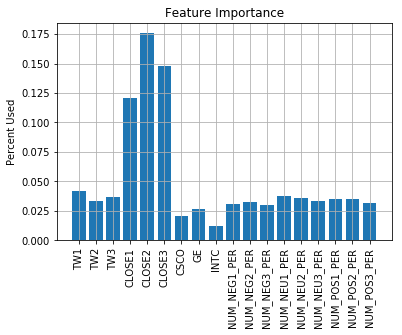

In [180]:
# illustrating most important features
best_featp, best_featpltp = features_full(data_noprev_per,rfcbp.feature_importances_, .01)

## Results:
K-nearest neighbors seems to be working by putting everything in the "no change" category, and does this even more when removing "OPEN" which also makes it put even more in there (slightly increasing the over all accuracy, but probably not enough to be worth it). 

The random forests (which for whatever reason, don't like lots of estimators) were interesting. They're much worse at putting "no change" in the right box, but are much better with the other two cateories, which is probably a good thing but it depends on what you want to do. Also, dropping the raw numbers and keeping "OPEN" makes the forest much worse than dropping the numbers and OPEN (which is currently the best model). This final model likes the sentiments more than when there is numbers. 


## Other Important Features:
Another option for narrowing down the features list (and making this a bit less overfitting in the long run) is to use industries instead of dummies for each company. We used [this website](https://www.thestreet.com) to determine which companies were classified into which industries. Only two, United Health Group and du Pont had no comparable groups, so we just left those dummies as is.

In [181]:
# classifying the stocks into industries
financial = ['AXP','GS','JPM','TRV']
electronic_tech = ['BA', 'CSCO', 'INTC']
producer_manu = ['CAT', 'GE', 'MMM','UTX']
minerals = ['CVX','XOM']
tech_services = ['IBM', 'MSFT','V']
basic_materials = ['DD']
consumer_services = ['DIS', 'MCD']
retail = ['HD','WMT']
health_tech = ['JNJ', 'MRK','PFE']
health_services = ['UNH']
non_durables = ['KO','NKE','PG']
comms = ['T','VZ']

industries = [financial, electronic_tech, producer_manu, minerals, consumer_services, tech_services, retail, 
              health_tech, non_durables, comms]

def industrifier(df,list_, drop=True):
    for i in range(len(df)):
        for e in list_:
            for x in e:
                if df.loc[i,x] == 1:
                    df.loc[i,str(e)] = 1
                else:
                    pass
    if drop==True:
        for e in list_:
            df.drop(columns=e, inplace=True)
        df.fillna(0,inplace=True)
    else:
        df.fillna(0,inplace=True)
    return df

In [194]:
#creating new dataset using industrified variables
data2 = pd.read_csv("/Users/jacobbills/Desktop/Economics/Twitter_sentiment_DJIA30/Combined_stocks.csv") 
data2 = industrifier(data2, industries, drop=True)
sentiments = ['NUM_NEG', 'NUM_NEG1', 'NUM_NEG2', 'NUM_NEG3','NUM_NEU','NUM_NEU1','NUM_NEU2','NUM_NEU3','NUM_POS',
              'NUM_POS1','NUM_POS2', 'NUM_POS3']
for e in sentiments:
    if e.endswith("1"):
        data2[e+"_PER"] = data2[e]/data2['TW1']
    elif e.endswith("2"):
        data2[e+"_PER"] = data2[e]/data2['TW2']
    elif e.endswith("3"):
        data2[e+"_PER"] = data2[e]/data2['TW3']
    else:
        data2[e+"_PER"] = data2[e]/data2['TW']
        
data2['Date']= pd.to_datetime(data2['Date'])
data2['day'] = data2['Date'].dt.day_name()
data2 = pd.get_dummies(data2, columns=['day'])
is_null = data2.columns[data2.isnull().any()] # seeing where there might be a problem
for e in is_null: #just fill them in with whatever is closest
    data2[e].fillna(data2[e].mean(), inplace=True)
for i in range(len(data2)): # create the classes
    if data2.loc[i,"CLOSE"] > data2.loc[i,"OPEN"]+.25:
        data2.loc[i,"class"] = 1 # gained by more than $.25
    elif data2.loc[i,"CLOSE"] < data2.loc[i,'OPEN']-.25:
        data2.loc[i,"class"] = 2 # lost by more than $.25 
    else:
        data2.loc[i,"class"] = 0 # minimal change
data2 = data2.loc[data2.weekend==0]
target2 = data2.CLOSE # target
target_class2 = data2["class"] # target for classifiers
high2 = data2.HIGH # other columns that we don't really need for now
low2 = data2.LOW
data2_prev = data2.drop(columns=['CLOSE', 'HIGH', 'LOW', 'Unnamed: 0', 'class', 'day_Saturday', 'day_Sunday', 'Date',
                            'NUM_NEG', 'NUM_NEU', 'NUM_POS', 'NUM_NEG_PER', 'NUM_NEU_PER', 'NUM_POS_PER', "TW"])
data2_nopen_prev = data2_prev.drop(columns=['OPEN'])
data2_prev_per = data2_prev.drop(columns=sentiments_prev)
data2_noprev_per = data2_nopen_prev.drop(columns=sentiments_prev)

In [198]:
# scale the new data
data2_prev_per = pd.DataFrame(data2_prev_per, dtype='float')
data2_noprev_per = pd.DataFrame(data2_noprev_per, dtype='float')
scaler.fit(data2_prev_per)
scaled2_prevperO = scaler.transform(data2_prev_per)

scaler.fit(data2_noprev_per)
scaled2_prevper = scaler.transform(data2_noprev_per)

X_trainPO2, X_testPO2, y_trainPO2, y_testPO2 = train_test_split(scaled2_prevperO, target_class2, test_size=.2, random_state = 11)
X_trainP2, X_testP2, y_trainP2, y_testP2 = train_test_split(scaled2_prevper, target_class2, test_size=.2, random_state = 11)

## KNN - Industrified:

In [199]:
# K Nearest Neighbors with open industrified
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainPO2, y_trainPO2)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainPO2)
print("Train F1: {}".format(f1_score(y_trainPO2, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testPO2)
print(classification_report(y_testPO2, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainPO2, y_pred_train),
                                                     accuracy_score(y_testPO2, y_pred_test)))
print(confusion_matrix(y_testPO2, y_pred_test))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Train F1: [0.67320261 0.50408298 0.44565499]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.66      0.58       801
         1.0       0.42      0.37      0.39       630
         2.0       0.34      0.26      0.29       536

   micro avg       0.46      0.46      0.46      1967
   macro avg       0.43      0.43      0.42      1967
weighted avg       0.44      0.46      0.44      1967

Train Accuracy: 0.5687221869040051	Test accuracy: 0.4550076258261312
[[525 154 122]
 [254 233 143]
 [232 167 137]]


In [200]:
# K Nearest Neighbors without open industrified
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_trainP2, y_trainP2)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainP2)
print("Train F1: {}".format(f1_score(y_trainP2, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testP2)
print(classification_report(y_testP2, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainP2, y_pred_train),
                                                     accuracy_score(y_testP2, y_pred_test)))
print(confusion_matrix(y_testP2, y_pred_test))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Train F1: [0.67362995 0.50144092 0.43826358]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.66      0.58       801
         1.0       0.41      0.36      0.39       630
         2.0       0.34      0.26      0.30       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.43      0.43      0.42      1967
weighted avg       0.44      0.45      0.44      1967

Train Accuracy: 0.5666878575969485	Test accuracy: 0.4539908490086426
[[526 156 119]
 [254 227 149]
 [232 164 140]]


## Visualizing the Data:
It seems like were hitting a wall with this data. We aren't able to gain much predictive power so we are going to print out heatmaps of our confusion matrices to better understand whats going on in our models

In [309]:
#taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

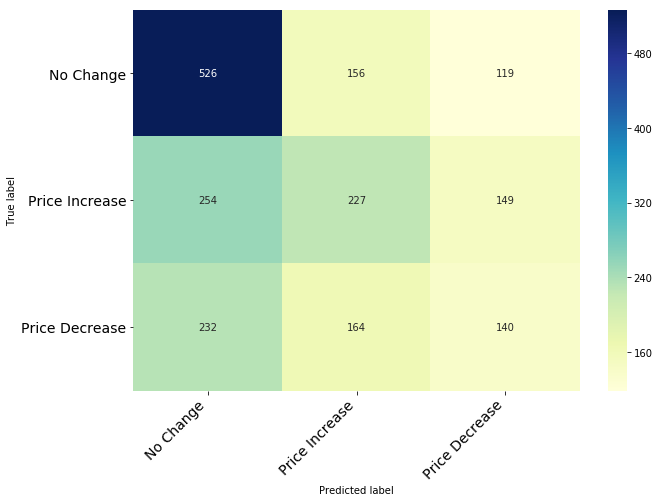

In [310]:
knnt = KNeighborsClassifier(n_neighbors=9,p=1,weights='uniform')
knnt.fit(X_trainP2, y_trainP2)
y_pred_train = knnt.predict(X_trainP2)
y_pred_test = knnt.predict(X_testP2)
cmknn = confusion_matrix(y_testP2, y_pred_test)
knngraph = print_confusion_matrix(cmknn,['No Change', 'Price Increase', 'Price Decrease'])

## Random Forest - Industrified:

In [201]:
# RFC industrified open
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainPO2, y_trainPO2)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainPO2)
print("Train F1: {}".format(f1_score(y_trainPO2, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testPO2)
print(classification_report(y_testPO2, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainPO2, y_pred_train),
                                                     accuracy_score(y_testPO2, y_pred_test)))
print(confusion_matrix(y_testPO2, y_pred_test))

Best Params: {'class_weight': 'balanced_subsample', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 200, 'random_state': 9}
Train F1: [0.60969655 0.58924645 0.56759463]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.51      0.57       801
         1.0       0.40      0.41      0.40       630
         2.0       0.30      0.38      0.33       536

   micro avg       0.44      0.44      0.44      1967
   macro avg       0.45      0.43      0.44      1967
weighted avg       0.47      0.44      0.45      1967

Train Accuracy: 0.5898283534647171	Test accuracy: 0.4428063040162684
[[409 175 217]
 [113 259 258]
 [113 220 203]]


In [202]:
# RFC industrified no open
rfc = RandomForestClassifier()
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_trainP2, y_trainP2)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_trainP2)
print("Train F1: {}".format(f1_score(y_trainP2, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_testP2)
print(classification_report(y_testP2, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_trainP2, y_pred_train),
                                                     accuracy_score(y_testP2, y_pred_test)))
print(confusion_matrix(y_testP2, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'n_estimators': 50, 'random_state': 9}
Train F1: [0.5998596  0.57521463 0.53786906]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.50      0.57       801
         1.0       0.40      0.46      0.43       630
         2.0       0.31      0.35      0.33       536

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.45      0.44      0.44      1967
weighted avg       0.48      0.45      0.46      1967

Train Accuracy: 0.5730451366815004	Test accuracy: 0.4489069649211998
[[403 204 194]
 [104 292 234]
 [106 242 188]]


In [203]:
rfcbpO2 = RandomForestClassifier(class_weight= 'balanced_subsample', max_depth= 7, max_features= 'sqrt', min_samples_leaf= 3, 
                               n_estimators= 200, random_state= 9)
rfcbpO2.fit(X_trainPO2, y_trainPO2)
rfcbp2 = RandomForestClassifier(class_weight= 'balanced', max_depth= 7, max_features= 'sqrt', min_samples_leaf= 9, 
                               n_estimators= 50, random_state= 9)
rfcbp2.fit(X_trainP2, y_trainP2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=9,
            verbose=0, warm_start=False)

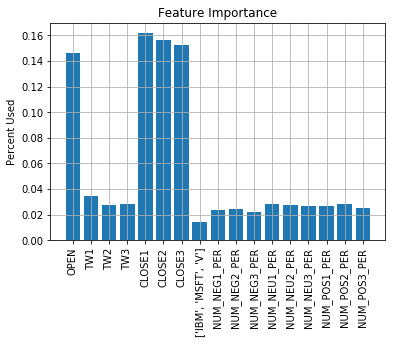

In [206]:
best_featpO2, best_featpltpO2 = features_full(data2_prev_per,rfcbpO2.feature_importances_, .01)

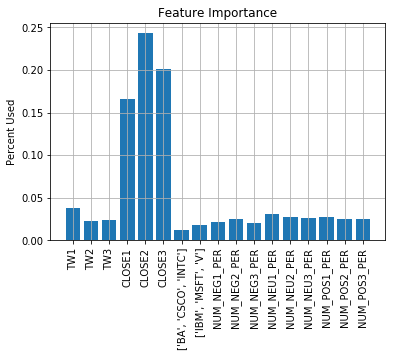

In [205]:
best_featp2, best_featpltp2 = features_full(data2_noprev_per,rfcbp2.feature_importances_, .01)

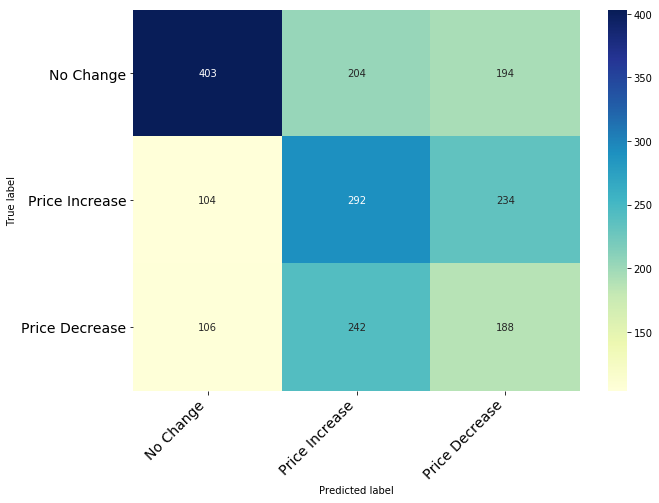

In [311]:
rfcbp2.fit(X_trainP2, y_trainP2)
y_pred_train = rfcbp2.predict(X_trainP2)
y_pred_test = rfcbp2.predict(X_testP2)
rfcm = confusion_matrix(y_testP2, y_pred_test)
rfgraph = print_confusion_matrix(rfcm,['No Change', 'Price Increase', 'Price Decrease'])

## Robustness Checks:
Next we are going to try our models on a whole bunch of training sets to see how robust the most accurate model (k-nn) is.

In [228]:
# Robustness on Nearest Neighbors
for i in range(10):
    print(i)
    z = np.random.randint(1,5)
    print(i*z)
    X_train, X_test, y_train, y_test = train_test_split(scaled2_prevper, target_class2, test_size=.2, random_state = i*z)
    knn = KNeighborsClassifier(n_neighbors= 9, p= 1, weights= 'uniform')
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
    print("Test Classification Report:")
    y_pred_test = knn.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                         accuracy_score(y_test, y_pred_test)))
    print(confusion_matrix(y_test, y_pred_test))
    print("\n")

0
0
Train F1: [0.66703403 0.51550712 0.4298459 ]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.68      0.60       849
         1.0       0.34      0.34      0.34       563
         2.0       0.32      0.20      0.25       555

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.40      0.41      0.40      1967
weighted avg       0.42      0.45      0.43      1967

Train Accuracy: 0.5652892561983471	Test accuracy: 0.4483985765124555
[[576 165 108]
 [242 194 127]
 [238 205 112]]


1
1
Train F1: [0.67038954 0.51100937 0.44619837]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.68      0.59       789
         1.0       0.38      0.33      0.35       629
         2.0       0.35      0.24      0.29       549

   micro avg       0.45      0.45      0.45      1967
   macro avg       0.42      0.42      0.41      1967
weighted avg       0.4

In [230]:
# random forest robustness check
for i in range(10): 
    print(i)
    z = np.random.randint(1,5)
    print(i*z)
    X_train, X_test, y_train, y_test = train_test_split(scaled2_prevper, target_class2, test_size=.2, random_state = i*z)
    rfc = RandomForestClassifier(class_weight= 'balanced', max_depth= 7, max_features= 'sqrt', min_samples_leaf= 9, 
                                   n_estimators= 50, random_state= 9)
    rfc.fit(X_train, y_train)
    y_pred_train = rfc.predict(X_train)
    print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
    print("Test Classification Report:")
    y_pred_test = rfc.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                         accuracy_score(y_test, y_pred_test)))
    print(confusion_matrix(y_test, y_pred_test))
    print("\n")

0
0
Train F1: [0.59472078 0.58012468 0.54089654]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59       849
         1.0       0.34      0.45      0.39       563
         2.0       0.30      0.32      0.31       555

   micro avg       0.44      0.44      0.44      1967
   macro avg       0.44      0.43      0.43      1967
weighted avg       0.47      0.44      0.45      1967

Train Accuracy: 0.5735537190082645	Test accuracy: 0.44026436197254704
[[438 211 200]
 [102 253 208]
 [108 272 175]]


1
2
Train F1: [0.59934062 0.57877051 0.54604727]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.52      0.58       797
         1.0       0.38      0.43      0.40       590
         2.0       0.36      0.42      0.39       580

   micro avg       0.46      0.46      0.46      1967
   macro avg       0.47      0.46      0.46      1967
weighted avg       0.

## Ensembling for Increased Predictive Power
We next try to ensemble our models together for an increase in predictive power. Ensembling KNN and Random Forest together seems like it might not be the worst idea, however using only two models seems to not improve anything. We should use more models in our ensemble.


In [232]:
# Ensembeling our data

#Weighted Average
model1 = KNeighborsClassifier(n_neighbors= 9, p= 1, weights= 'uniform')
model2 = RandomForestClassifier(class_weight= 'balanced', max_depth= 7, max_features= 'sqrt', min_samples_leaf= 9, 
                                   n_estimators= 50, random_state= 9)

X_train, X_test, y_train, y_test = train_test_split(scaled2_prevper, target_class2, test_size=.2, random_state = 42)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

pred1=model1.predict_proba(X_test)
pred2=model2.predict_proba(X_test)

finalpred = (pred1*0.3+pred2*0.7)

In [303]:
# ensembling using a voting classifier method
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('knn', model1), ('dt', model2), ('gb', gbcb)], voting='hard')
model.fit(X_train,y_train)
print(model.score(X_test, y_test))
y_pred_train = model.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

0.41382816471784445
Train F1: [0.63966411 0.49963724 0.45467544]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.71      0.55       792
         1.0       0.35      0.24      0.29       602
         2.0       0.34      0.19      0.24       573

   micro avg       0.41      0.41      0.41      1967
   macro avg       0.38      0.38      0.36      1967
weighted avg       0.39      0.41      0.38      1967

Train Accuracy: 0.5617291799109981	Test accuracy: 0.41382816471784445
[[560 132 100]
 [349 147 106]
 [324 142 107]]


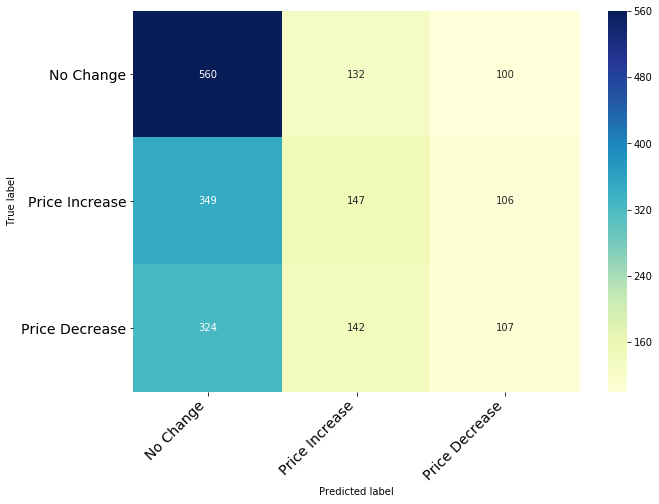

In [312]:
# printing a confusion matrix to visualize how well our ensemble performed
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
modelcm = confusion_matrix(y_test, y_pred_test)
votegraph = print_confusion_matrix(modelcm,['No Change', 'Price Increase', 'Price Decrease'])

In [257]:
# importing some different ensembling libraries to try other methods
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

### AdaBoost:

In [255]:
# trying an AdaBoostClassifier - Not much better
model = AdaBoostClassifier(random_state=1)
model.fit(X_train,y_train)

0.44738179969496694

### Gradient Boosting:

In [258]:
gbcb = GradientBoostingClassifier(n_estimators= 5000, max_depth = 3, learning_rate = .1, 
                                  n_iter_no_change=5, random_state = 0)
gbcb.fit(X_train, y_train)
print(gbcb.n_estimators_)

27


In [261]:
gbcb = GradientBoostingClassifier(n_estimators= 30, max_depth = 3, learning_rate = .1, 
                                  n_iter_no_change=5, random_state = 0)
gbcb.fit(X_train, y_train)
y_pred_train = gbcb.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gbcb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Train F1: [0.63953645 0.48890575 0.28722003]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.73      0.62       792
         1.0       0.41      0.47      0.44       602
         2.0       0.42      0.14      0.22       573

   micro avg       0.48      0.48      0.48      1967
   macro avg       0.46      0.45      0.42      1967
weighted avg       0.46      0.48      0.45      1967

Train Accuracy: 0.5210425937698665	Test accuracy: 0.4809354346720895
[[580 168  44]
 [249 283  70]
 [258 232  83]]


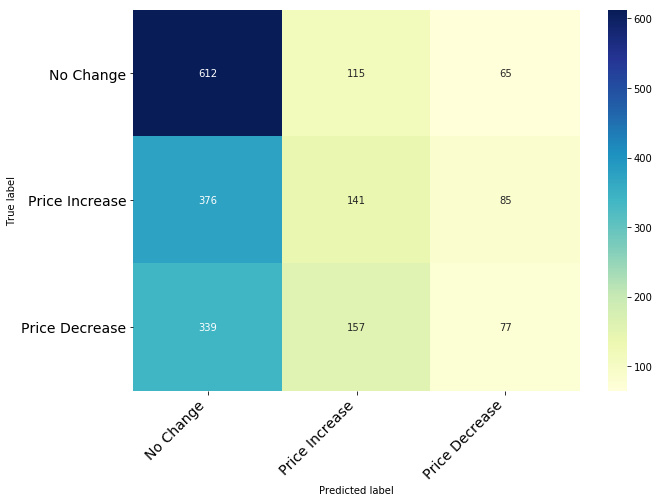

In [313]:
gbcb.fit(X_train, y_train)
y_pred_train = gbcb.predict(X_train)
y_pred_test = gbcb.predict(X_test)
gbcm = confusion_matrix(y_test, y_pred_test)
gbgraph = print_confusion_matrix(gbcm,['No Change', 'Price Increase', 'Price Decrease'])

### Ridge Classifier:

In [262]:
from sklearn.linear_model import RidgeClassifierCV
rc = RidgeClassifierCV(alphas=[.1,1,5,10])
rc.fit(X_train, y_train)
y_pred_train = rc.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = rc.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Train F1: [0.6198044  0.41473281 0.16754294]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.80      0.62       792
         1.0       0.43      0.38      0.40       602
         2.0       0.33      0.10      0.15       573

   micro avg       0.47      0.47      0.47      1967
   macro avg       0.42      0.43      0.39      1967
weighted avg       0.43      0.47      0.41      1967

Train Accuracy: 0.4765416401780038	Test accuracy: 0.46619217081850534
[[634 103  55]
 [318 227  57]
 [317 200  56]]


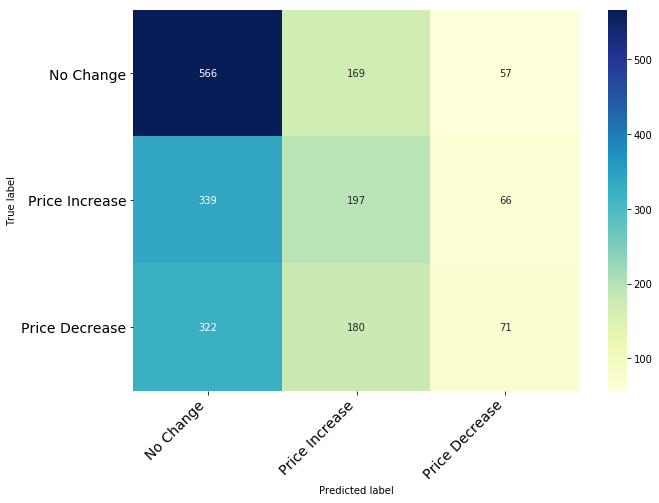

In [314]:
rc.fit(X_train, y_train)
y_pred_train = rc.predict(X_train)
y_pred_test = rc.predict(X_test)
rccm = confusion_matrix(y_test, y_pred_test)
rcgraph = print_confusion_matrix(rccm,['No Change', 'Price Increase', 'Price Decrease'])

In [277]:
noprice = data2_nopen_prev.drop(columns=['CLOSE1','CLOSE2','CLOSE3'])
noprice = pd.DataFrame(noprice, dtype='float')

In [283]:
scaler.fit(noprice)
scaled_noprice = scaler.transform(noprice)

X_train, X_test, y_train, y_test = train_test_split(scaled_noprice, target_class2, test_size=.2, random_state = 42)

In [279]:
# No closing data
gridsearch = GridSearchCV(rfc, {"n_estimators": [20, 50, 100, 200, 500], "max_depth": [1, 3, 5, 7, 9, 11], 
                                 "min_samples_leaf": [3 , 5 , 7 , 9], "max_features": [None, 'sqrt', 'log2']
                                , "class_weight": ["balanced", "balanced_subsample"], 'random_state': [9]}, 
                          scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Best Params: {'class_weight': 'balanced', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 50, 'random_state': 9}
Train F1: [0.71857073 0.74096386 0.73177027]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.48       792
         1.0       0.35      0.39      0.37       602
         2.0       0.32      0.32      0.32       573

   micro avg       0.40      0.40      0.40      1967
   macro avg       0.39      0.39      0.39      1967
weighted avg       0.40      0.40      0.40      1967

Train Accuracy: 0.7295613477431659	Test accuracy: 0.40010167768174887
[[370 225 197]
 [184 235 183]
 [183 208 182]]


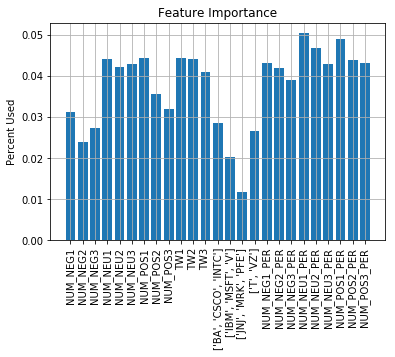

In [282]:
rfclos = RandomForestClassifier(n_estimators=50, random_state=9,class_weight='balanced', max_depth=11, 
                                max_features='sqrt', min_samples_leaf=7)
rfclos.fit(X_train, y_train)
best_featcl, best_pltcl = features_full(noprice,rfclos.feature_importances_, .01)

In [284]:
gbcb = GradientBoostingClassifier(n_estimators= 5000, max_depth = 3, learning_rate = .1, 
                                  n_iter_no_change=5, random_state = 0)
gbcb.fit(X_train, y_train)
print(gbcb.n_estimators_)

52


In [285]:
gbcb = GradientBoostingClassifier(n_estimators= 52, max_depth = 3, learning_rate = .1, 
                                  random_state = 0)
gbcb.fit(X_train, y_train)
y_pred_train = gbcb.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gbcb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Train F1: [0.62338268 0.40604436 0.31692913]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.46      0.77      0.58       792
         1.0       0.34      0.23      0.28       602
         2.0       0.34      0.13      0.19       573

   micro avg       0.42      0.42      0.42      1967
   macro avg       0.38      0.38      0.35      1967
weighted avg       0.39      0.42      0.37      1967

Train Accuracy: 0.5073108709472346	Test accuracy: 0.42196237925775293
[[612 115  65]
 [376 141  85]
 [339 157  77]]


In [286]:
rc = RidgeClassifierCV(alphas=[.1,1,5,10])
rc.fit(X_train, y_train)
y_pred_train = rc.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = rc.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Train F1: [0.58591065 0.37413495 0.18796484]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.46      0.71      0.56       792
         1.0       0.36      0.33      0.34       602
         2.0       0.37      0.12      0.19       573

   micro avg       0.42      0.42      0.42      1967
   macro avg       0.40      0.39      0.36      1967
weighted avg       0.40      0.42      0.38      1967

Train Accuracy: 0.4488239033693579	Test accuracy: 0.42399593289273
[[566 169  57]
 [339 197  66]
 [322 180  71]]


In [287]:
gridsearch = GridSearchCV(knn, {"n_neighbors": [5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_micro', cv=3)
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Best Params: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Train F1: [0.62231535 0.4666955  0.36080692]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.65      0.53       792
         1.0       0.36      0.33      0.34       602
         2.0       0.35      0.18      0.24       573

   micro avg       0.41      0.41      0.41      1967
   macro avg       0.39      0.38      0.37      1967
weighted avg       0.40      0.41      0.39      1967

Train Accuracy: 0.5188811188811189	Test accuracy: 0.4123029994916116
[[511 189  92]
 [307 198  97]
 [310 161 102]]
